## Simple example of kriging in gempy

In this notebook it will be shown how to create a kriged or simulated field in a simple geological model in gempy. We start by creating a simple model with three horizontally layered units, as shown in the gempy examples.

In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")


# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

# new for this
import importlib
from gempy.assets import kriging

np.random.seed(5555)

Creating the model by importing the input data and displaying it:

In [2]:
data_path= '../..'

geo_data = gp.create_data([0,1000,0,50,0,1000],resolution=[50,1,50], 
                        path_o = data_path+"/data/input_data/jan_models/model1_orientations.csv",
                        path_i = data_path+"/data/input_data/jan_models/model1_surface_points.csv") 

Active grids: ['regular']


Setting and ordering the units and series:

In [3]:
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Strat_Series,1,False,#015482,1
1,rock1,Strat_Series,2,False,#9f0052,2
2,basement,Basement_Series,1,True,#ffbe00,3


In [4]:
#%matplotlib inline
#gp.plot.plot_data(geo_data, direction='y')

Calculating the model:

In [5]:
interp_data = gp.set_interpolation_data(geo_data, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [6]:
# no mesh computed as basically 2D model
sol = gp.compute_model(geo_data, compute_mesh=False)

So here is the very simple, basically 2D model that we created:

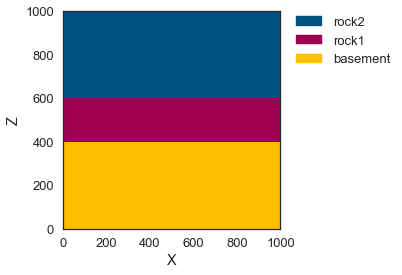

In [7]:
gp.plot.plot_section(geo_data, cell_number=0, show_legend=True, show_data=False)

## 1) Creating domain

Let us assume we have a couple of measurements in a domain of interest within our model. In our case the unit of interest is the central rock layer ("rock1"). In the kriging module we can define the domain by handing over a number of surfaces by id - in this case the id of rock1 is 2. In addition we define four input data points in cond_data, each defined by x,y,z coordinate and a measurement value.

In [8]:
# conditioning data (data measured at locations)
cond_data = np.array([[100,.5,500,2],[900,.5,500,1],[500,.5,550,1],[300,.5,400,5]])

In [9]:
# creating a domain object from the gempy solution, a defined domainand conditioning data
domain = kriging.domain(model=sol, domain=[2], data=cond_data)

## 2) Creating a variogram model

In [10]:
variogram_model = kriging.variogram_model(theoretical_model = 'exponential', range_=200, sill=np.var(cond_data[:,3]))

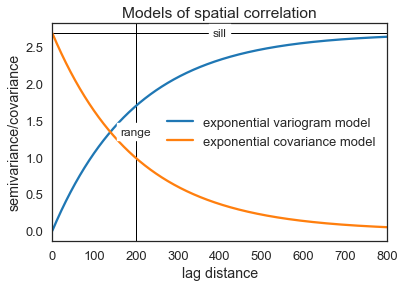

In [11]:
variogram_model.plot(type_='both', show_parameters = True)

## 3) Kriging interpolation

In the following we define an object called kriging_model and set all input parameters. Finally we generate the kriged field.

In [12]:
solution = kriging.create_kriged_field(domain, variogram_model)

The result of our calculation is saved in the following dataframe, containing an estimated value and the kriging variance for each point in the grid:

In [13]:
solution.results_df.head()

,X,Y,Z,estimated value,estimation variance
0,10.0,0.5,410.0,2.241527,2.103574
1,10.0,0.5,430.0,2.193533,1.979653
2,10.0,0.5,450.0,2.144314,1.865246
3,10.0,0.5,470.0,2.097843,1.774740
4,10.0,0.5,490.0,2.058490,1.724742


It is also possible to plot the results in cross section similar to the way gempy models are plotted.

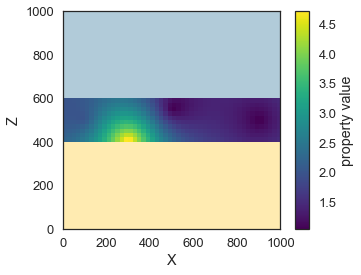

In [14]:
solution.plot_results(geo_data=geo_data, prop='val', contour=False, direction='y', cell_number=0, alpha=0.7,
                          show_data=False, legend=True)

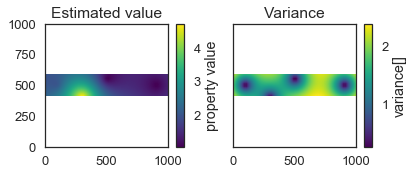

In [15]:
solution.plot_results(geo_data=geo_data, prop='both', contour=False, direction='y', cell_number=0, alpha=0,
                          interpolation='bilinear', show_data=False)

## 4) Simulated field

Based on the same objects (domain and varigoram model) also a simulated field (stationary Gaussian Field) can be generated. A Sequential Gaussian Simulation approach is applied in this module:

In [16]:
solution_sim = kriging.create_gaussian_field(domain, variogram_model)

In [17]:
solution_sim.results_df.head()

,X,Y,Z,estimated value,estimation variance
16,10.0,0.5,410.0,2.642725,1.480064
157,10.0,0.5,430.0,2.414133,0.281501
276,10.0,0.5,450.0,4.019788,0.238778
25,10.0,0.5,470.0,2.585805,0.528127
267,10.0,0.5,490.0,0.809643,0.281643


In [18]:
solution_sim.results_df['estimated value']

16     2.642725
157    2.414133
276    4.019788
25     2.585805
267    0.809643
481    0.524439
184    0.150723
424   -0.799371
84     0.081723
376    0.517850
369    2.126173
92     2.597314
129    3.458446
415    1.685619
14     1.550341
256    0.863639
437    1.209301
120   -0.405240
4      0.456935
159    1.725151
245    1.755836
131    2.219214
385    2.079305
378    1.493618
351    2.205196
443    1.602555
453    1.479129
50     1.682184
139    2.002079
420    2.421079
         ...   
292    1.917281
356    1.745136
132    2.342710
403    2.108304
35     2.322587
295    2.483762
152    3.465020
250    2.117275
494    1.001908
422    1.069882
21     2.302120
91     1.927553
257    2.835414
309    2.904920
48     3.384884
449    4.048059
124    3.037036
313    2.272841
382    2.015106
466    0.412165
39     1.472486
96     2.644132
13     1.858980
242    3.062386
191    4.395441
55     3.762014
165    3.332039
427    2.028748
303    1.981516
187    2.068681
Name: estimated value, L

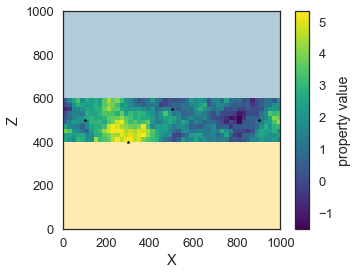

In [19]:
solution_sim.plot_results(geo_data=geo_data, prop='val', contour=False, direction='y', cell_number=0, alpha=0.7,
                          show_data=True, legend=True)

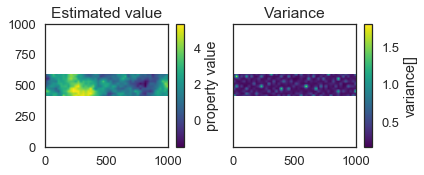

In [20]:
solution_sim.plot_results(geo_data=geo_data, prop='both', contour=False, direction='y', cell_number=0, alpha=0,
                          interpolation='bilinear', show_data=False)